In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yfinance_loader import download_tickers

%matplotlib inline

In [13]:
tickers = pd.read_csv('ticker_lists/ndx.csv', header=None)

In [14]:
tickers = tickers[0].to_list()

In [41]:
tickers = ['GOM']
stocks = download_tickers(tickers, False, return_only=['Adj Close'])

[*********************100%***********************]  1 of 1 completed


In [42]:
close = stocks.loc[:, stocks.columns.get_level_values(1).isin(['Adj Close'])].iloc[-4000:-1, :]
close = close.dropna()

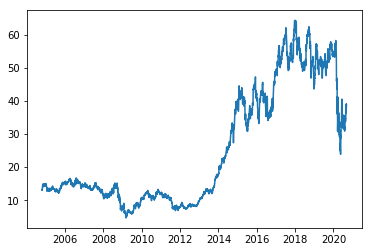

In [43]:
sns.lineplot(data=close.mean(axis=1))